In [1]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns

import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    'E:\\diplom\\datasets\\sorry\\300x300\\train',
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=32,
    image_size=(300, 300),
    shuffle = True
)

ds_val = tf.keras.preprocessing.image_dataset_from_directory(
    'E:\\diplom\\datasets\\sorry\\300x300\\test',
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=32,
    image_size=(300, 300),
    shuffle = True,
)

val_batches = tf.data.experimental.cardinality(ds_val)
ds_test = ds_val.take(val_batches // 5)
ds_val = ds_val.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(ds_val))
print('Number of test batches: %d' % tf.data.experimental.cardinality(ds_test))

Found 9378 files belonging to 2 classes.
Found 6110 files belonging to 2 classes.
Number of validation batches: 153
Number of test batches: 38


In [3]:
AUTOTUNE = tf.data.AUTOTUNE

ds_train = ds_train.prefetch(buffer_size=AUTOTUNE)
ds_val = ds_val.prefetch(buffer_size=AUTOTUNE)
ds_test = ds_test.prefetch(buffer_size=AUTOTUNE)

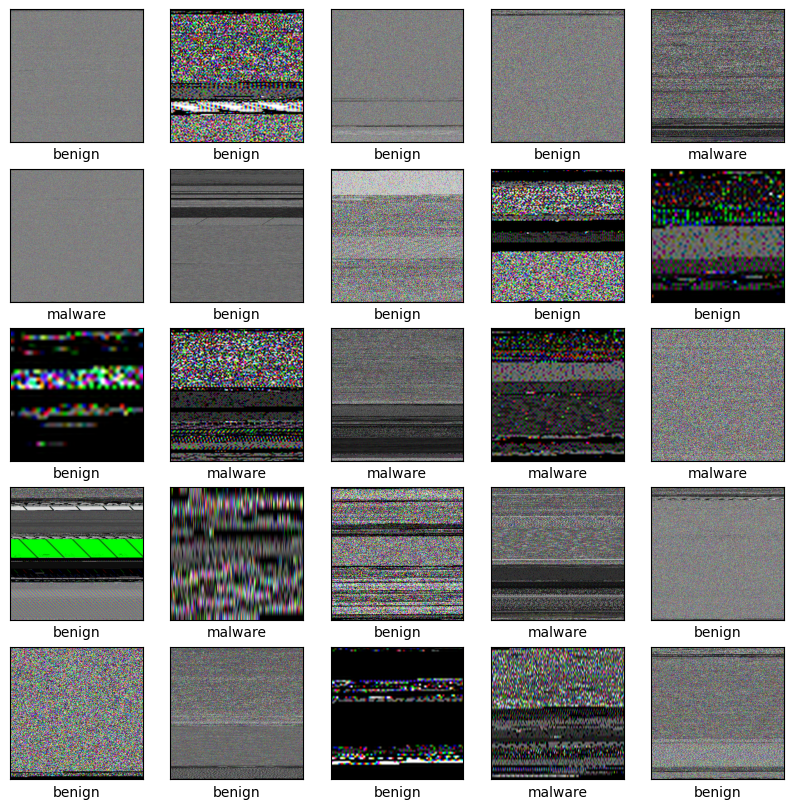

In [4]:
class_names = ["malware", "benign"]

for images, labels in ds_train.take(1):
    images = np.array(images.numpy(), np.uint8)
    plt.figure(figsize=(10,10))
    for i in range(25):
        c = np.argmax(labels[i])
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i])
        plt.xlabel(class_names[c])
    plt.show()
    break

In [5]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [6]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(300, 300, 3),
                                               include_top=False,
                                               weights='imagenet')

In [7]:
image_batch, label_batch = next(iter(ds_train))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 10, 10, 1280)


In [8]:
base_model.trainable = False

In [9]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 150, 150, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 150, 150, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [10]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [11]:
prediction_layer = tf.keras.layers.Dense(2)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 2)


In [12]:
inputs = tf.keras.Input(shape=(300, 300, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [13]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 300, 300, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 300, 300, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 10, 10, 1280)     2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

In [15]:
len(model.trainable_variables)

2

In [16]:
# Number of epochs for model training (increase for the better accuracy)
initial_epochs = 20

loss0, accuracy0 = model.evaluate(ds_val)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

153/153 [==============================] - 233s 1s/step - loss: 0.8693 - accuracy: 0.4879
initial loss: 0.87
initial accuracy: 0.49


In [17]:
history = model.fit(ds_train,
                    epochs=initial_epochs,
                    validation_data=ds_val)

Epoch 1/20
294/294 [==============================] - 620s 2s/step - loss: 0.5435 - accuracy: 0.7344 - val_loss: 0.6011 - val_accuracy: 0.6553
Epoch 2/20
294/294 [==============================] - 617s 2s/step - loss: 0.4248 - accuracy: 0.8163 - val_loss: 0.5270 - val_accuracy: 0.7362
Epoch 3/20
294/294 [==============================] - 616s 2s/step - loss: 0.3818 - accuracy: 0.8364 - val_loss: 0.4720 - val_accuracy: 0.7781
Epoch 4/20
294/294 [==============================] - 621s 2s/step - loss: 0.3640 - accuracy: 0.8463 - val_loss: 0.4580 - val_accuracy: 0.7893
Epoch 5/20
294/294 [==============================] - 614s 2s/step - loss: 0.3459 - accuracy: 0.8582 - val_loss: 0.4452 - val_accuracy: 0.8012
Epoch 6/20
294/294 [==============================] - 618s 2s/step - loss: 0.3403 - accuracy: 0.8562 - val_loss: 0.4292 - val_accuracy: 0.8139
Epoch 7/20
294/294 [==============================] - 619s 2s/step - loss: 0.3311 - accuracy: 0.8612 - val_loss: 0.4205 - val_accuracy: 0.8173

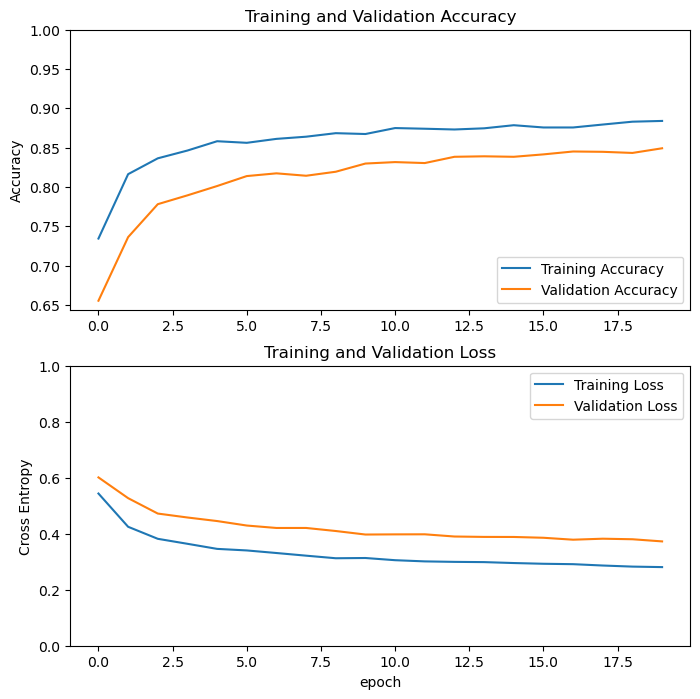

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
model.save("saloviho_DP_classification-sorry-binary")

In [ ]:
base_model.trainable = True

In [21]:
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [22]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [23]:
# Number of epochs for fine-tuning (increase for better accuracy)
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(ds_train,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=ds_val)

Epoch 20/30
294/294 [==============================] - 833s 3s/step - loss: 0.2846 - accuracy: 0.8796 - val_loss: 0.4913 - val_accuracy: 0.7552
Epoch 21/30
294/294 [==============================] - 842s 3s/step - loss: 0.2395 - accuracy: 0.9031 - val_loss: 0.3537 - val_accuracy: 0.8590
Epoch 22/30
294/294 [==============================] - 847s 3s/step - loss: 0.2070 - accuracy: 0.9122 - val_loss: 0.3796 - val_accuracy: 0.8525
Epoch 23/30
294/294 [==============================] - 843s 3s/step - loss: 0.1862 - accuracy: 0.9223 - val_loss: 0.4042 - val_accuracy: 0.8472
Epoch 24/30
294/294 [==============================] - 866s 3s/step - loss: 0.1703 - accuracy: 0.9292 - val_loss: 0.3251 - val_accuracy: 0.8684
Epoch 25/30
294/294 [==============================] - 860s 3s/step - loss: 0.1534 - accuracy: 0.9383 - val_loss: 0.3984 - val_accuracy: 0.8602
Epoch 26/30
294/294 [==============================] - 855s 3s/step - loss: 0.1400 - accuracy: 0.9425 - val_loss: 0.4359 - val_accuracy:

In [24]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

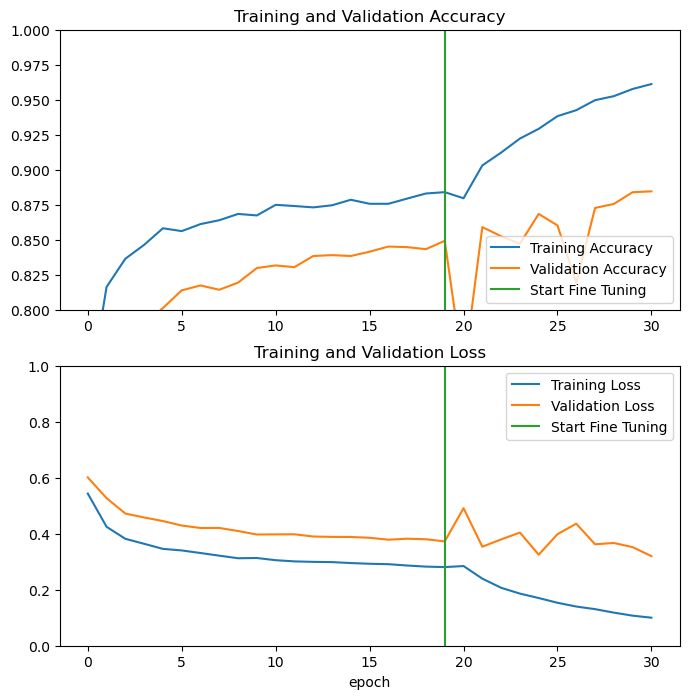

In [25]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [52]:
loss, accuracy = model.evaluate(ds_train)
print('Training accuracy :', accuracy)

294/294 [==============================] - 326s 1s/step - loss: 0.1149 - accuracy: 0.9576
Training accuracy : 0.9575602412223816


In [50]:
loss, accuracy = model.evaluate(ds_val)
print('Validation accuracy :', accuracy)

153/153 [==============================] - 165s 1s/step - loss: 0.3144 - accuracy: 0.8864
Validation accuracy : 0.8863915205001831


Predictions:
 [0 1 1 0 1 0 1 0 1 0 0 1 1 1 0 1 0 1 1 0 1 0 1 0 0 1 1 0 1 1 0 1 0 1 0 1 0
 1 1 0 0 1 0 1 0 1 1 0 1 0 0 1 1 0 0 1 1 1 0 1 1 0 1 0]
Labels:
 [[0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]


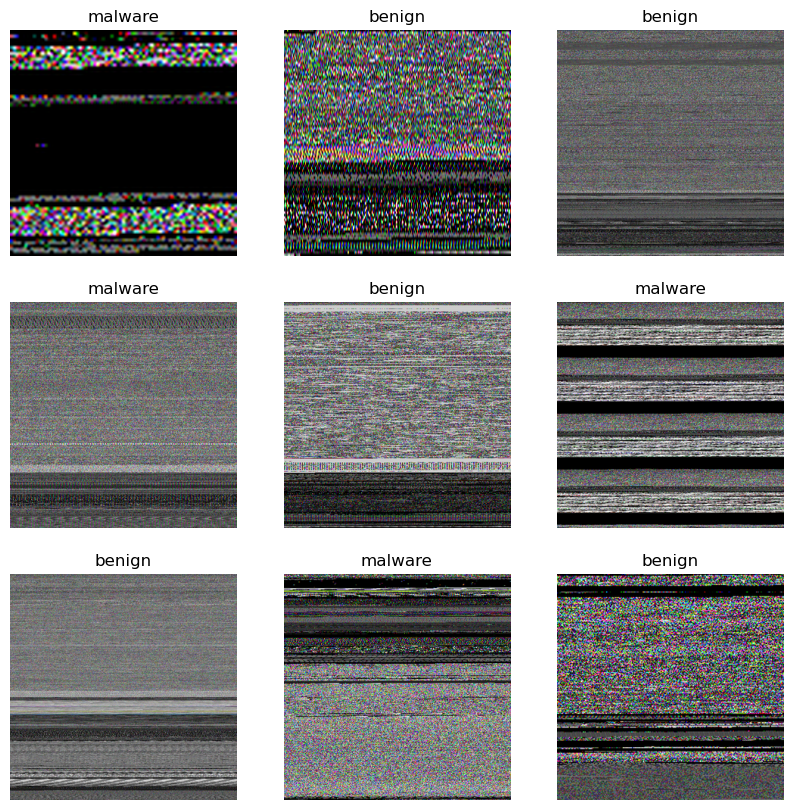

In [27]:
image_batch, label_batch = ds_test.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

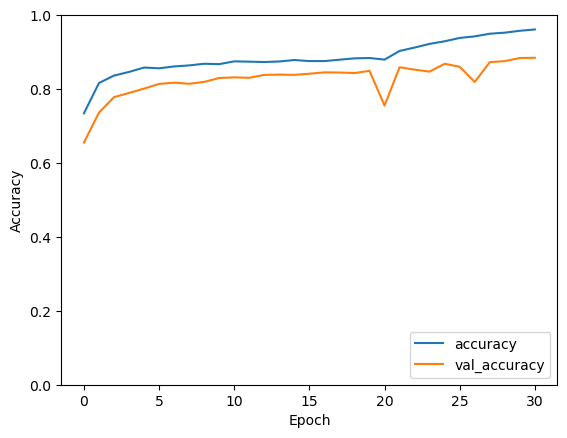

In [28]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [51]:
test_loss, test_acc = model.evaluate(ds_test)
print(test_acc)

38/38 [==============================] - 43s 1s/step - loss: 0.3126 - accuracy: 0.8840
0.8840460777282715


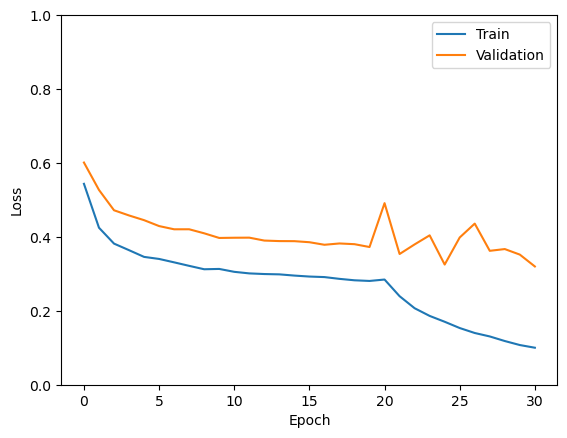

In [30]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.ylabel('Loss')

max_loss = max(history.history['loss'] + history.history['val_loss'])

plt.ylim([0, np.ceil(max_loss)])
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation']) 

In [36]:
def get_actual_predicted_labels(dataset):
    actual = None
    predicted = None
    for batch in dataset.as_numpy_iterator():
        image_batch, label_batch = batch
        predictions = model.predict_on_batch(image_batch)
        if predicted is None:
            predicted = np.argmax(predictions, axis=1)
            actual = np.argmax(label_batch, axis=1)
        else:
            predicted = np.concatenate((predicted, np.argmax(predictions, axis=1)))
            actual = np.concatenate((actual, np.argmax(label_batch, axis=1)))
    return actual, predicted

In [37]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True)
  sns.set(rc={'figure.figsize':(26, 26)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Class')
  ax.set_ylabel('Actual Class')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

In [40]:
def calculate_classification_metrics(y_actual, y_pred, labels):
  """
    Calculate the precision and recall of a classification model using the ground truth and
    predicted values. 

    Args:
      y_actual: Ground truth labels.
      y_pred: Predicted labels.
      labels: List of classification labels.

    Return:
      Precision and recall measures.
  """
  cm = tf.math.confusion_matrix(y_actual, y_pred)
  tp = np.diag(cm) # Diagonal represents true positives
  precision = dict()
  recall = dict()
  for i in range(len(labels)):
    col = cm[:, i]
    fp = np.sum(col) - tp[i] # Sum of column minus true positive is false negative

    row = cm[i, :]
    fn = np.sum(row) - tp[i] # Sum of row minus true positive, is false negative
    precision[labels[i]] = tp[i] / (tp[i] + fp) # Precision 

    recall[labels[i]] = tp[i] / (tp[i] + fn) # Recall

  return precision, recall

In [38]:
actual, predicted = get_actual_predicted_labels(ds_train)

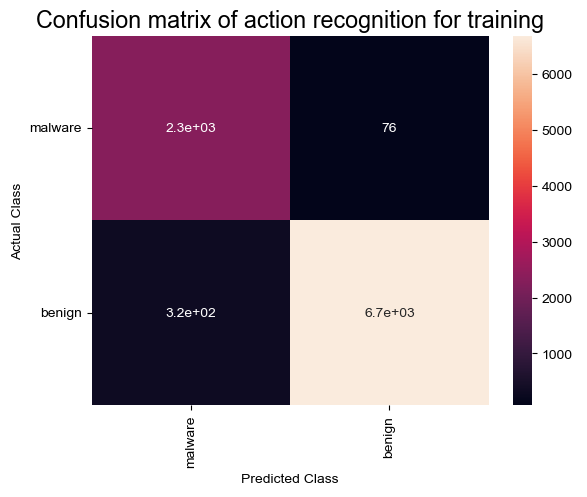

In [39]:
plot_confusion_matrix(actual, predicted, class_names, 'training')

In [42]:
precision, recall = calculate_classification_metrics(actual, predicted, class_names)
malware_count = np.count_nonzero(actual)
benign_count = len(actual) - malware_count

print(malware_count)
print(benign_count)

balanced_precision = ((precision["benign"] * benign_count) + (precision["malware"] * malware_count)) / (malware_count + benign_count)
balanced_recall = ((recall["benign"] * benign_count) + (recall["malware"] * malware_count)) / (malware_count + benign_count)
balanced_f1 = 2 * balanced_precision * balanced_recall / (balanced_precision + balanced_recall)

print(balanced_precision)
print(balanced_recall)
print(balanced_f1)

7000
2378
0.905549950525386
0.9644801226713703
0.9340865046889371


In [43]:
actual, predicted = get_actual_predicted_labels(ds_val)

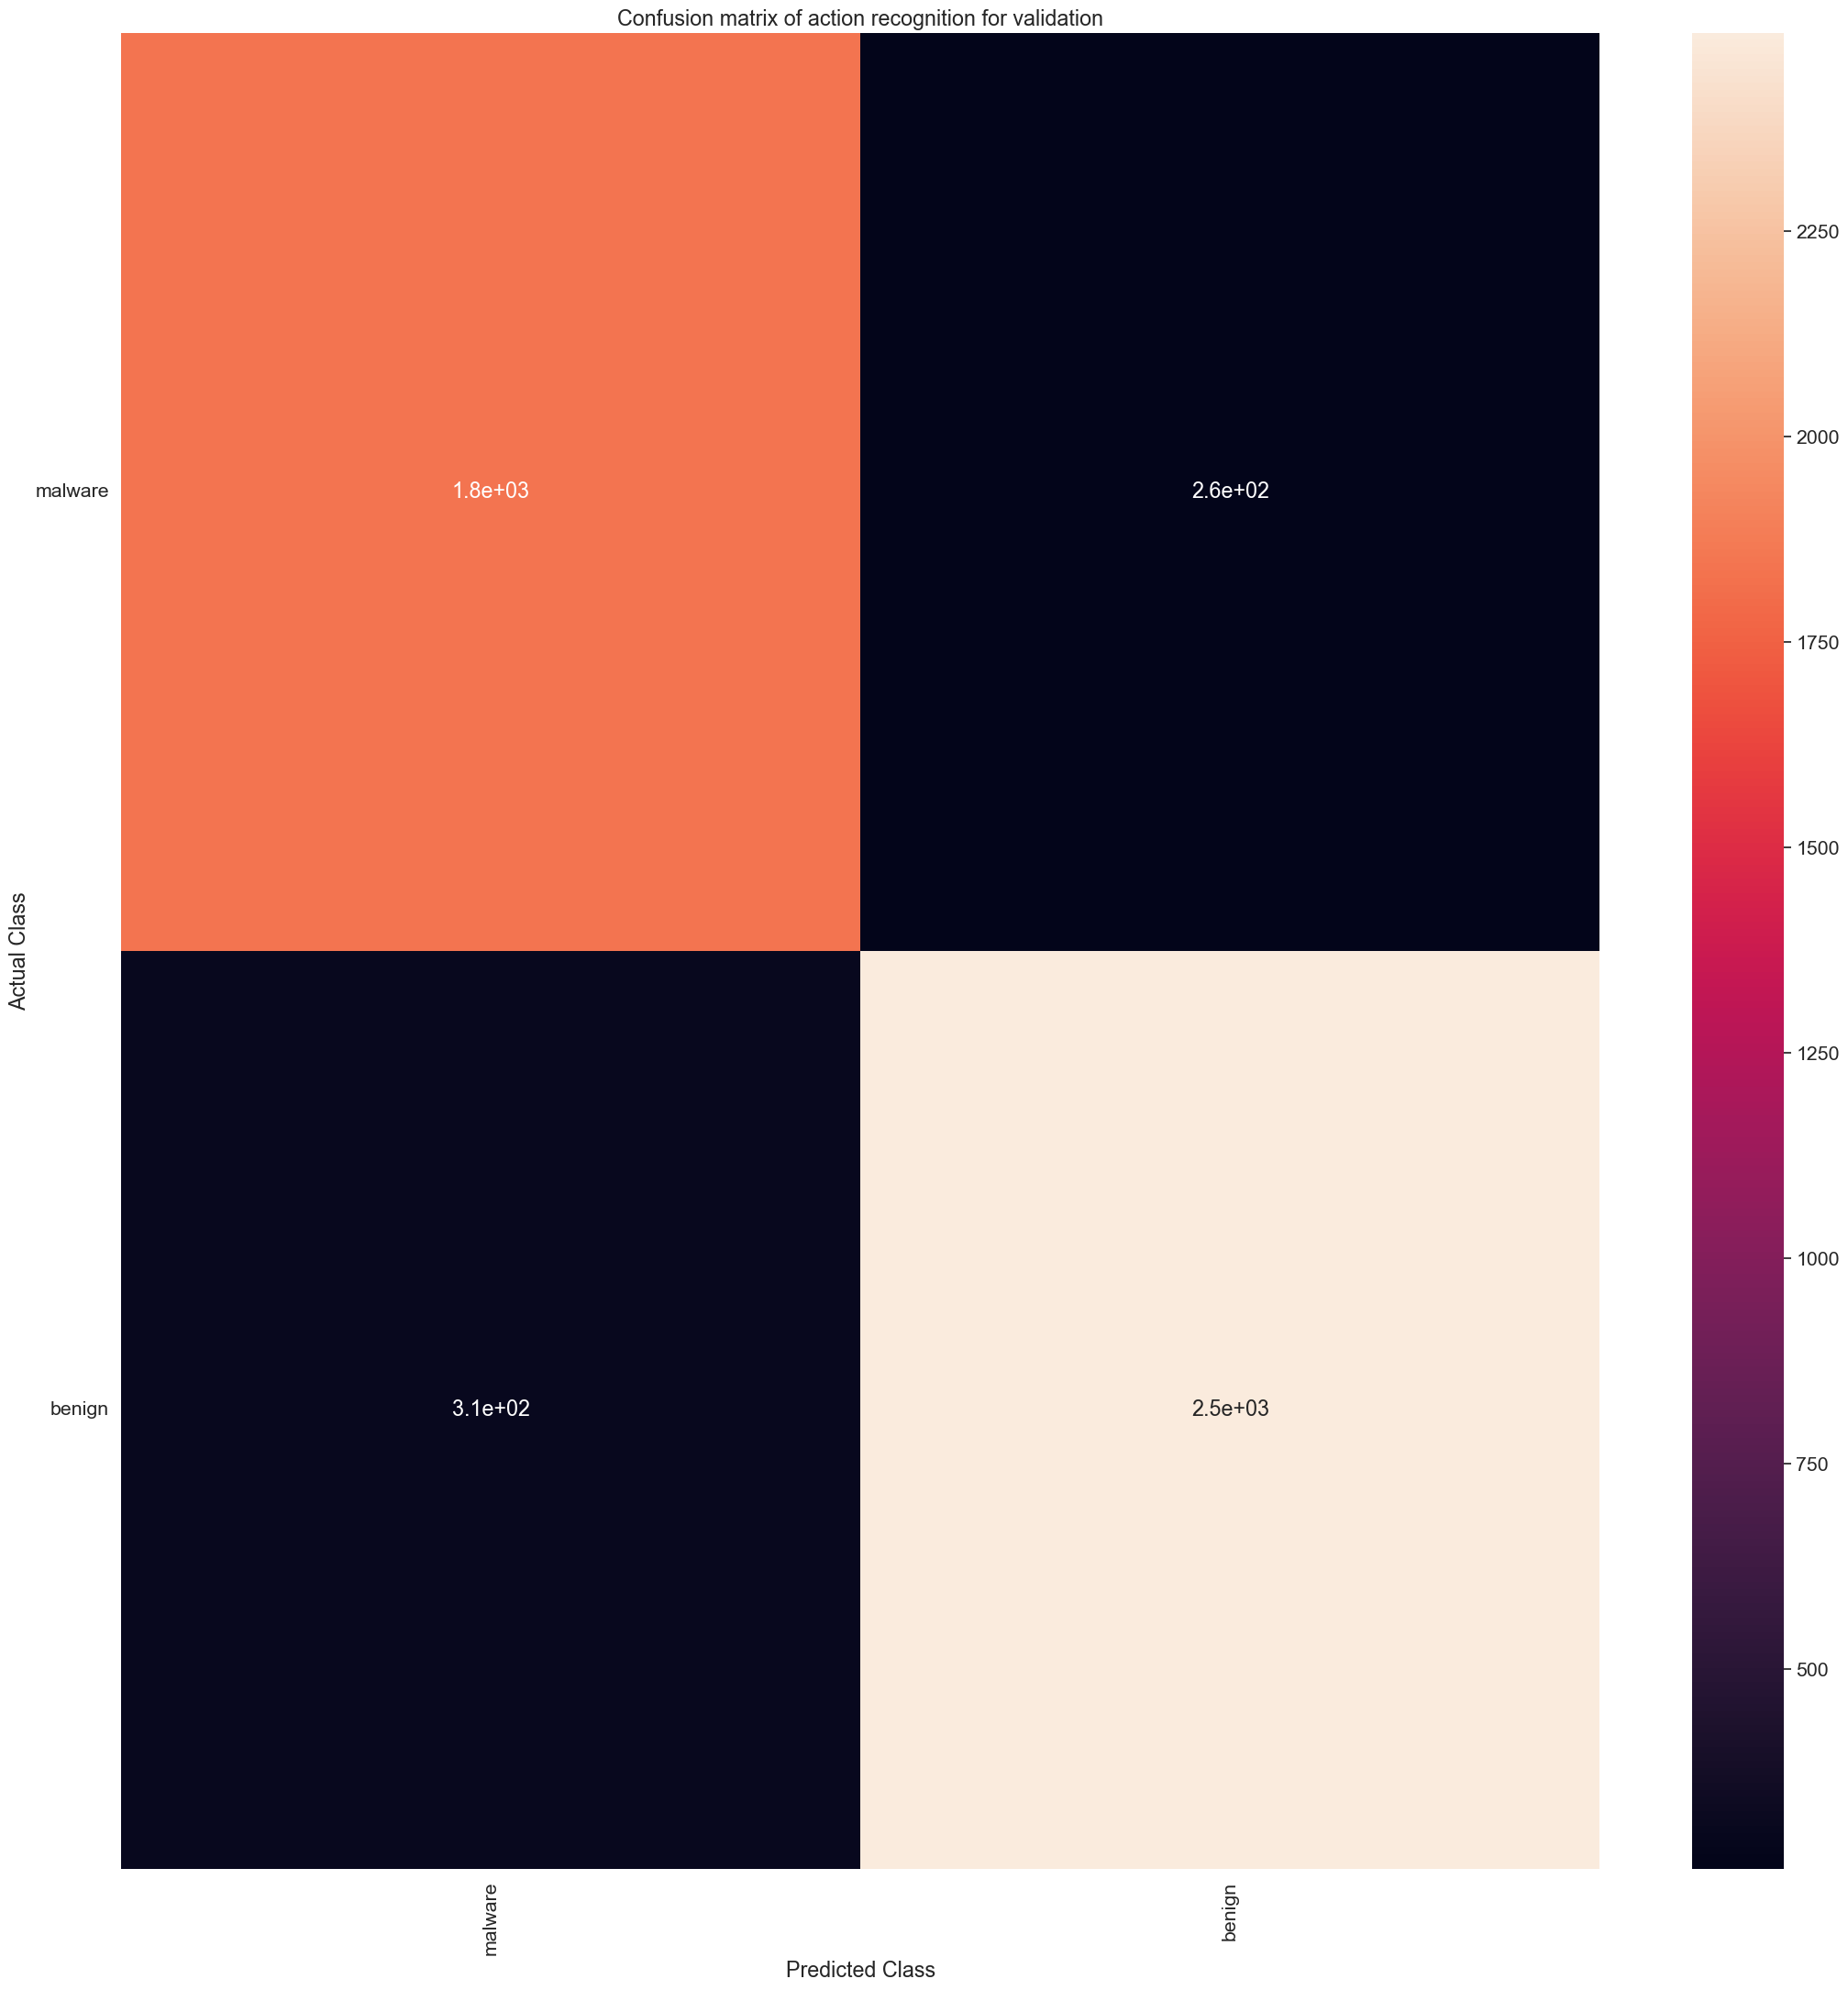

In [44]:
plot_confusion_matrix(actual, predicted, class_names, 'validation')

In [45]:
precision, recall = calculate_classification_metrics(actual, predicted, class_names)
malware_count = np.count_nonzero(actual)
benign_count = len(actual) - malware_count

print(malware_count)
print(benign_count)

balanced_precision = ((precision["benign"] * benign_count) + (precision["malware"] * malware_count)) / (malware_count + benign_count)
balanced_recall = ((recall["benign"] * benign_count) + (recall["malware"] * malware_count)) / (malware_count + benign_count)
balanced_f1 = 2 * balanced_precision * balanced_recall / (balanced_precision + balanced_recall)

print(balanced_precision)
print(balanced_recall)
print(balanced_f1)

2797
2097
0.8784341098349978
0.8830798589088048
0.880750858112093


In [46]:
actual, predicted = get_actual_predicted_labels(ds_test)

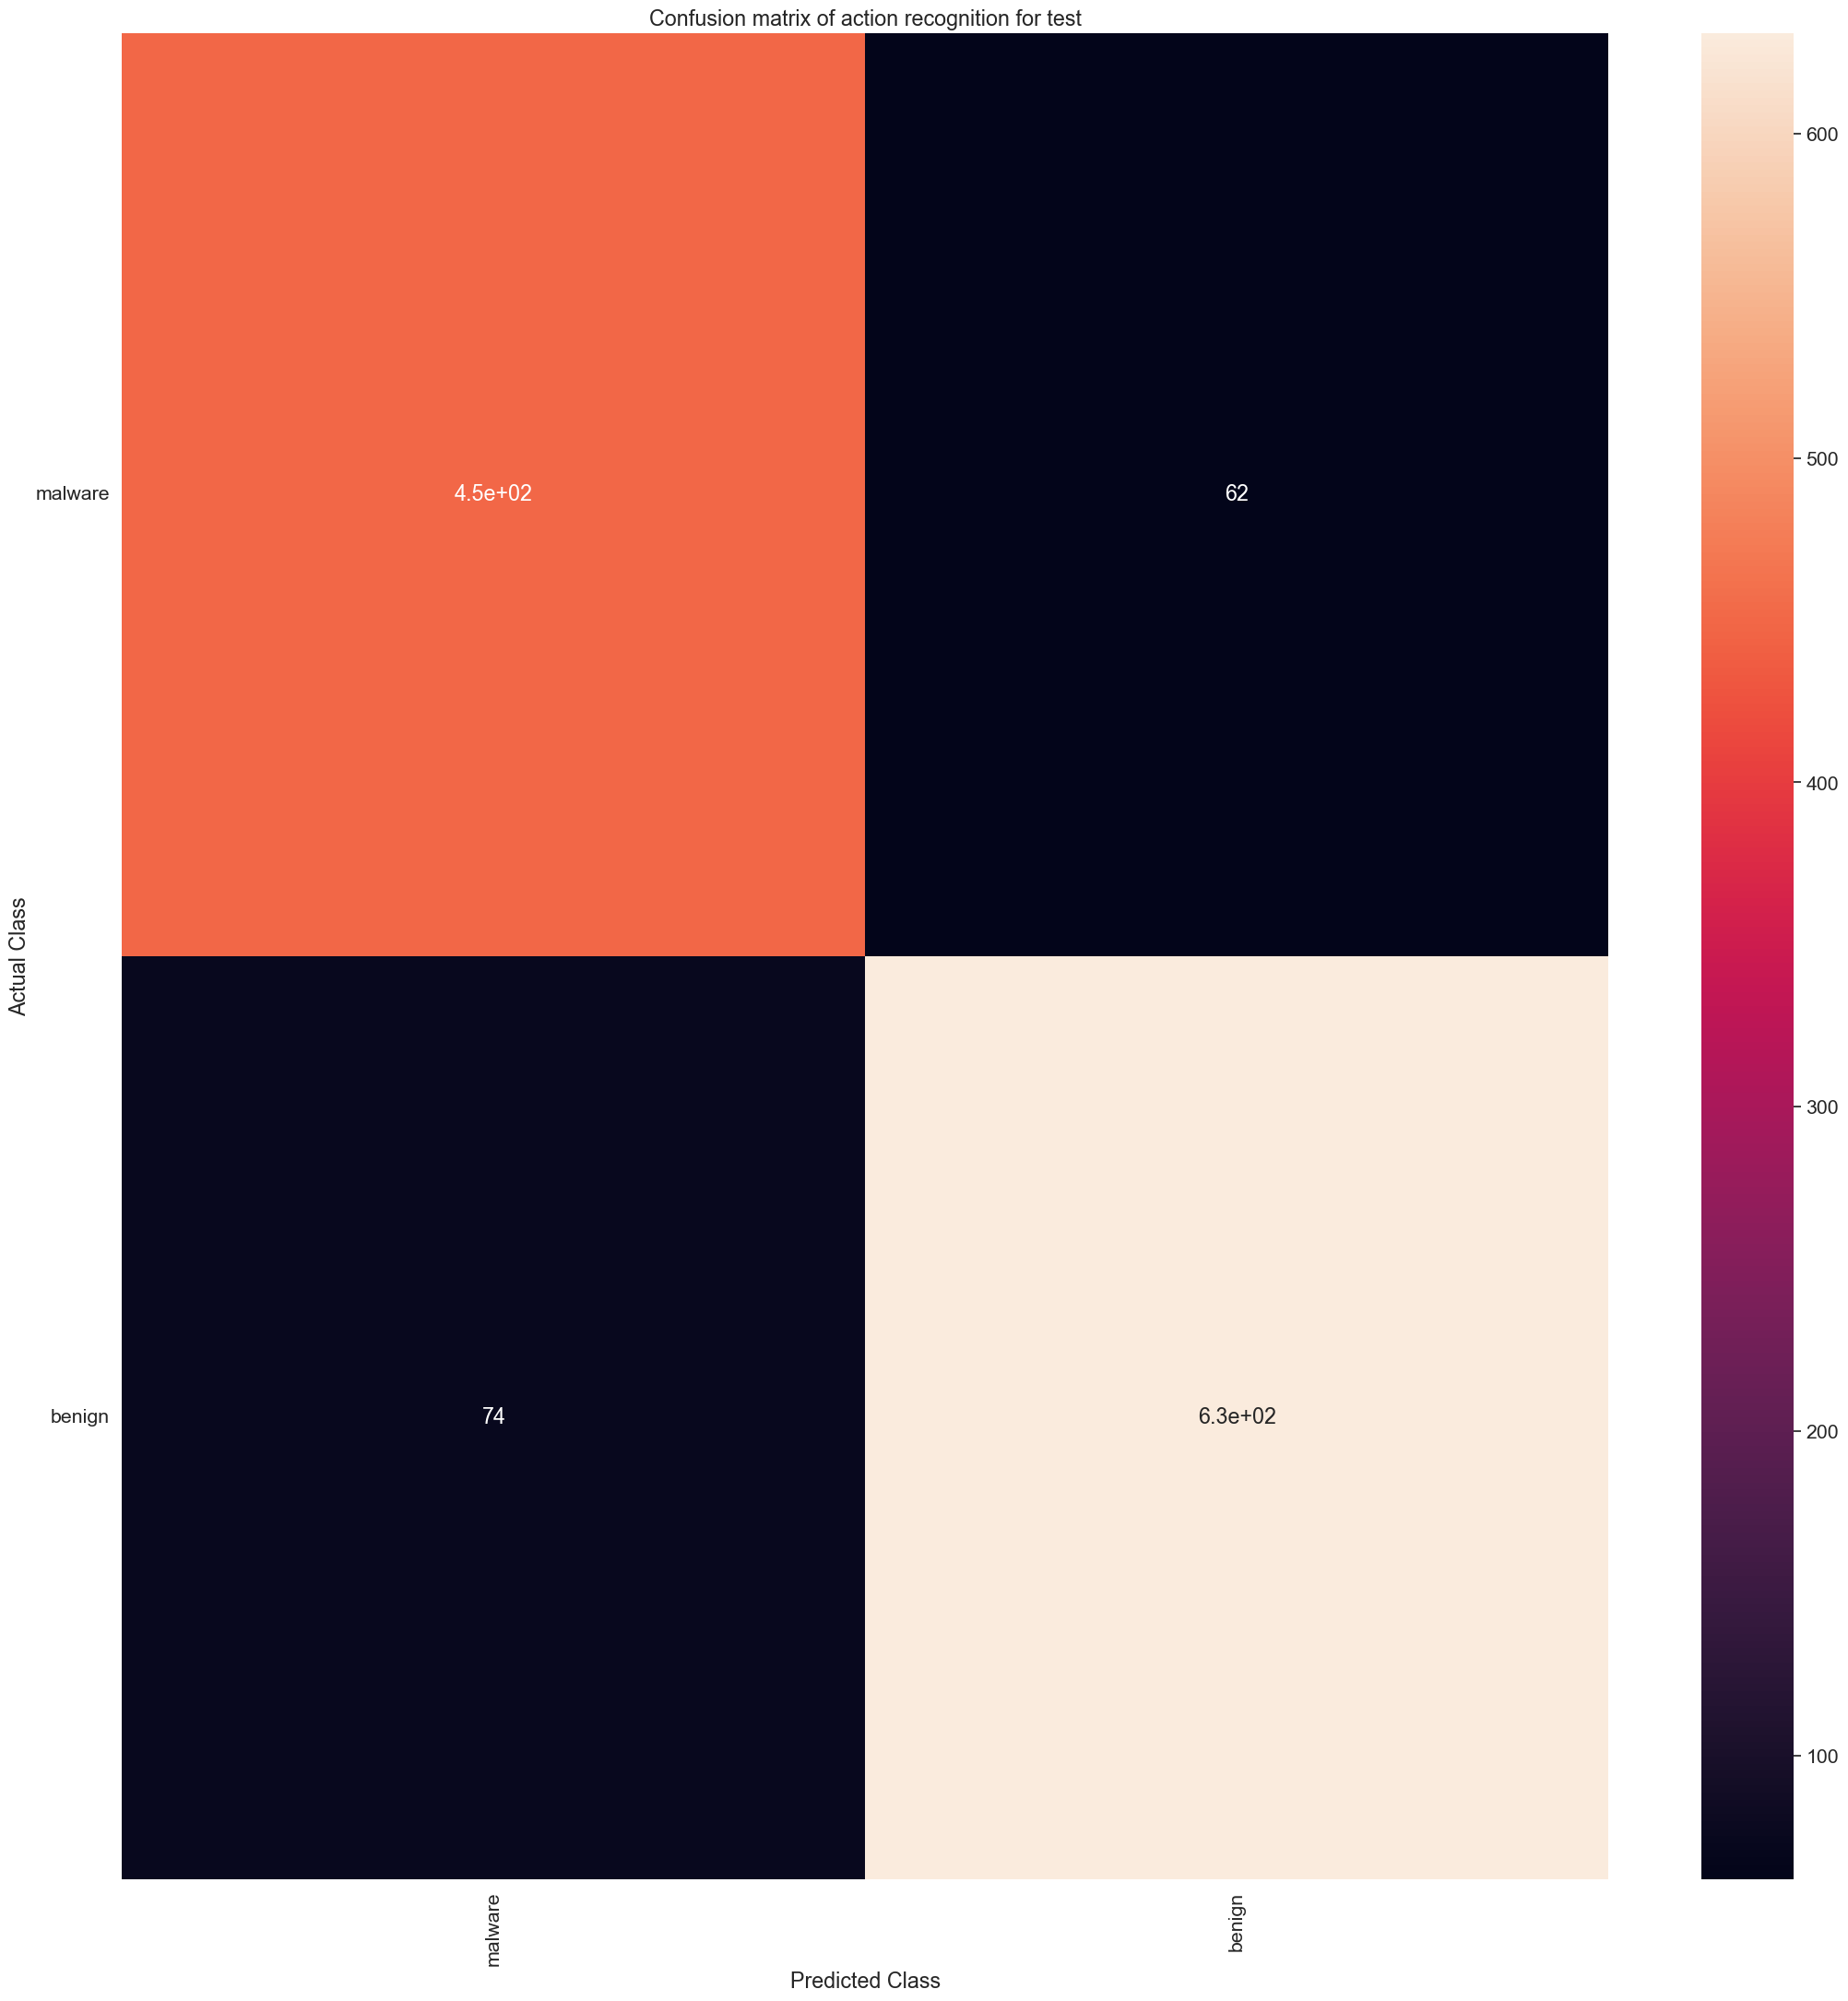

In [47]:
plot_confusion_matrix(actual, predicted, class_names, 'test')

In [48]:
precision, recall = calculate_classification_metrics(actual, predicted, class_names)
malware_count = np.count_nonzero(actual)
benign_count = len(actual) - malware_count

print(malware_count)
print(benign_count)

balanced_precision = ((precision["benign"] * benign_count) + (precision["malware"] * malware_count)) / (malware_count + benign_count)
balanced_recall = ((recall["benign"] * benign_count) + (recall["malware"] * malware_count)) / (malware_count + benign_count)
balanced_f1 = 2 * balanced_precision * balanced_recall / (balanced_precision + balanced_recall)

print(balanced_precision)
print(balanced_recall)
print(balanced_f1)

705
511
0.8803712123753384
0.8855468421856155
0.8829514427994577


Predictions:
 [0 0 0 1 0 0 1 1 0 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 1 0 0 1 0 1 0]
Labels:
 [0 0 0 1 0 0 1 1 0 1 1 0 0 1 0 1 0 1 1 1 1 1 0 0 1 1 0 0 1 0 1 0]


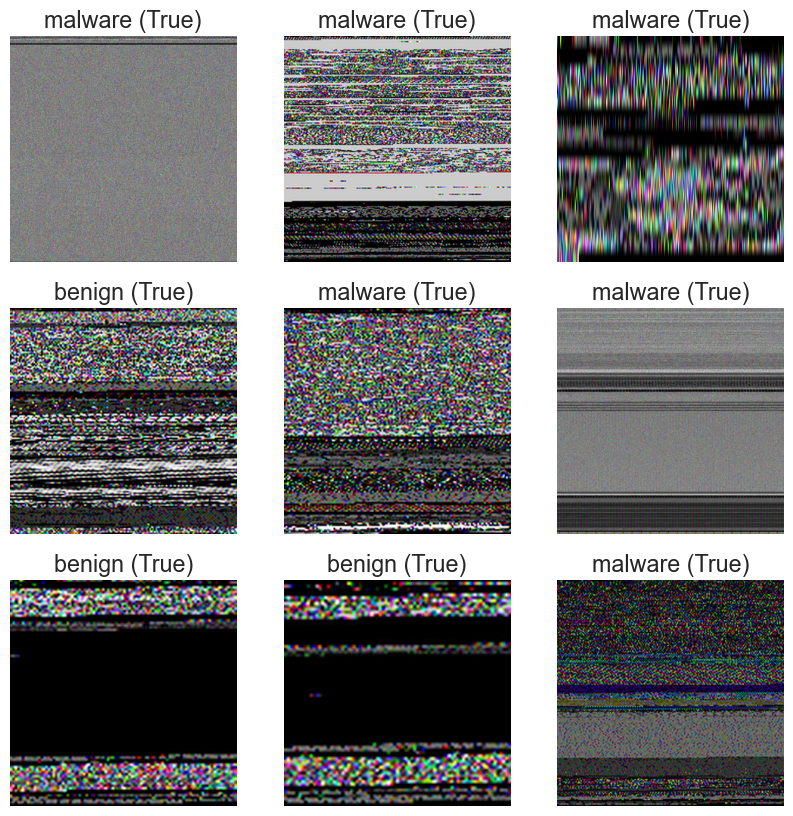

In [53]:
image_batch, label_batch = ds_val.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
predictions = np.argmax(predictions, axis=1)
label_batch = np.argmax(label_batch, axis=1)

print('Predictions:\n', predictions)
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(f"{class_names[predictions[i]]} ({predictions[i] == label_batch[i]})")
  plt.axis("off")

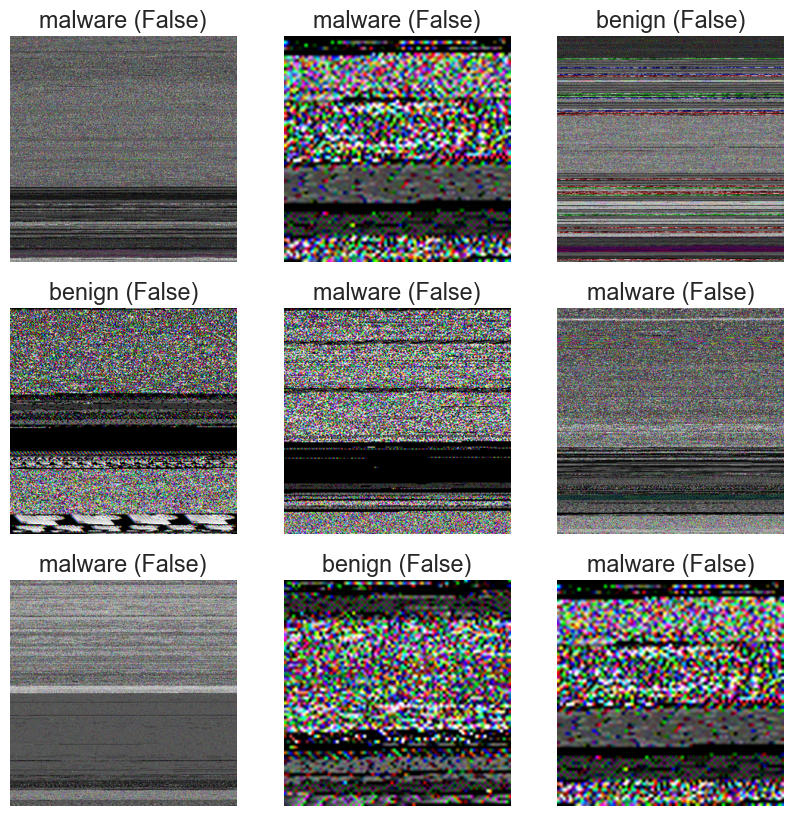

In [55]:
index = 1

plt.figure(figsize=(10, 10))
for image_batch, label_batch in ds_test.as_numpy_iterator():
    predictions = model.predict_on_batch(image_batch)
    predictions = np.argmax(predictions, axis=1)
    label_batch = np.argmax(label_batch, axis=1)

    #print('Predictions:\n', predictions)
    #print('Labels:\n', label_batch)
    for i in range(9):
      if predictions[i] == label_batch[i]:
          i = i - 1
          continue
      ax = plt.subplot(3, 3, index)
      plt.imshow(image_batch[i].astype("uint8"))
      plt.title(f"{class_names[predictions[i]]} ({predictions[i] == label_batch[i]})")
      plt.axis("off")
      index += 1
      if index > 9:
        break
    if index > 9:
        break

In [ ]:
precision, recall = calculate_classification_metrics(actual, predicted, class_names)

In [ ]:
precision

In [ ]:
recall

In [ ]:
f1_scores = {}
for key in precision:
    p = precision[key]
    r = recall[key]
    if p + r == 0:
        f1 = 0
    else:
        f1 = 2 * (p * r) / (p + r)
    f1_scores[key] = f1

f1_scores

In [ ]:
malware_count = np.count_nonzero(actual)
benign_count = len(actual) - malware_count

print(malware_count)
print(benign_count)

balanced_precision = ((precision["Benign"] * benign_count) + (precision["Malware"] * malware_count)) / (malware_count + benign_count)
balanced_recall = ((recall["Benign"] * benign_count) + (recall["Malware"] * malware_count)) / (malware_count + benign_count)
balanced_f1 = 2 * balanced_precision * balanced_recall / (balanced_precision + balanced_recall)

print(balanced_precision)
print(balanced_recall)
print(balanced_f1)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'model' is your pre-defined model
layer = model.layers[3].layers[1]  # Adjust this as per your model's architecture
filters = layer.get_weights()[0]  # Extract filters
n_filters = filters.shape[3]  # Number of filters
n_channels = filters.shape[2]  # Number of channels per filter

# Total number of images to plot
n_images = n_filters * n_channels

# Determine the size of the grid
n_cols = 3
n_rows = n_images // n_cols + (n_images % n_cols != 0)  # Compute rows needed

# Create a figure with subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))

# Normalize filter values to [0, 1] range for better visualization
#filters_min, filters_max = filters.min(), filters.max()
#filters = (filters - filters_min) / (filters_max - filters_min)

# Plot each filter's channels
image_index = 0
for i in range(n_filters):
    for k in range(n_channels):
        ax = axs[image_index // n_cols, image_index % n_cols]
        f = filters[:, :, k, i]
        
        for x in range(f.shape[0]):
            for y in range(f.shape[1]):
                ax.text(y, x, f[x, y], fontsize=8, ha='center', va='center', color='black')
        
        ax.imshow(f, cmap='coolwarm')#,  vmin=0, vmax=1)
        ax.axis('off')
        image_index += 1

# Hide any remaining empty subplots
for idx in range(image_index, n_rows * n_cols):
    axs[idx // n_cols, idx % n_cols].axis('off')

plt.subplots_adjust(wspace=0.01, hspace=0.01)
plt.tight_layout()
# Display the plot
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

# Load your image
img_path = 'ransomware.png'
img = image.load_img(img_path, target_size=(300, 300))  # Adjust target_size as per your model's input shape
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Normalize if required by your model

# Assuming 'model' is your pre-defined model
intermediate_layer_model = Model(inputs=model.layers[3].input,
                                 outputs=model.layers[3].layers[1].output)

# Get the feature maps

filters = intermediate_layer_model.layers[-1].get_weights()[0]
print(np.sum(filters[:, :, :, 3]))


feature_maps = intermediate_layer_model.predict(img_array)
print(feature_maps.shape)  # This will give you the shape of the feature maps

# Determine the number of feature maps
n_features = feature_maps.shape[-1]

# Determine the grid size for plotting
n_cols = 2  # Number of columns in the grid
n_rows = n_features // n_cols  # Number of rows in the grid

# Plot the feature maps
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 64))

for i in range(n_rows):
    for j in range(n_cols):
        ax = axs[i, j]
        feature_map_index = i * n_cols + j
        if feature_map_index < n_features:
            ax.imshow(feature_maps[0, :, :, feature_map_index], cmap='gray')
            ax.axis('off')
        else:
            ax.axis('off')

plt.subplots_adjust(wspace=0.01, hspace=0.01)
plt.tight_layout()
plt.show()

#### 